# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will grade your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 bonus points by achieving an accuracy of 85%+.


The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-CIFAR10.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 1.7 MB 71.0 MB/s 
     |████████████████████████████████| 6.0 MB 47.6 MB/s 
     |████████████████████████████████| 439 kB 65.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
tf.keras.__version__

'2.11.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

170498071/170498071 [==============================] - 2s 0us/step


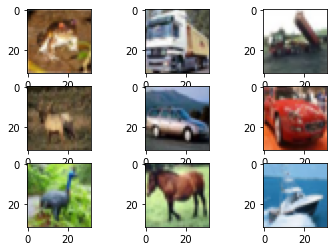

X train: (50000, 32, 32, 3)
y train: (50000, 10)
X test:  (10000, 32, 32, 3)
y test:  (10000, 10)


In [ ]:
from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

# raw images: various sizes + each pixel 3 int vals [0, 255] (RGB)
# x a great fit for feeding a neural network
# -> preprocess: adequate your image to the format the model requires
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

print('X train: ' + str(X_train_full.shape)) # 60K images / dimension 28*28 / 1 channel
print('y train: ' + str(y_train_full.shape))
print('X test:  '  + str(X_test.shape))
print('y test:  '  + str(y_test.shape))

## Build and train the model

Build and train your model. 

In [ ]:
# TODO: load the model you selected
# https://keras.io/guides/transfer_learning/
# 1. Instantiate a base model and load pre-trained weights into it.
base_model = tf.keras.applications.ResNet50(
    include_top=False, # Do not include the ImageNet classifier at the top
    weights="imagenet", # Load weights pre-trained on ImageNet
    input_shape=(256, 256, 3)
)

# Freeze the base_model
for layer in base_model.layers:
    layer.trainable=False
    
# TODO: Transfer learning - build your own model based on the selected model
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
# show the structure of your model
model.build(X_train_full.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (50000, 64, 64, 3)       0         
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (50000, 128, 128, 3)     0         
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (50000, 256, 256, 3)     0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (50000, 131072)           0         
                                                        

In [ ]:
from keras.optimizers import Adam
learn_rate = .001
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train end-to-end
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
1407/1407 [==============================] - 216s 144ms/step - loss: 1.1427 - accuracy: 0.6160 - val_loss: 0.5882 - val_accuracy: 0.8028
Epoch 2/15
1407/1407 [==============================] - 206s 146ms/step - loss: 0.7681 - accuracy: 0.7490 - val_loss: 0.5202 - val_accuracy: 0.8296
Epoch 3/15
1407/1407 [==============================] - 205s 145ms/step - loss: 0.6202 - accuracy: 0.7978 - val_loss: 0.4823 - val_accuracy: 0.8348
Epoch 4/15
1407/1407 [==============================] - 203s 145ms/step - loss: 0.5318 - accuracy: 0.8270 - val_loss: 0.4729 - val_accuracy: 0.8402
Epoch 5/15
1407/1407 [==============================] - 205s 146ms/step - loss: 0.4765 - accuracy: 0.8447 - val_loss: 0.4818 - val_accuracy: 0.8396
Epoch 6/15
1407/1407 [==============================] - 204s 145ms/step - loss: 0.4119 - accuracy: 0.8651 - val_loss: 0.4787 - val_accuracy: 0.8388
Epoch 7/15
1407/1407 [==============================] - 204s 145ms/step - loss: 0.3696 - accuracy: 0.8805 - val_

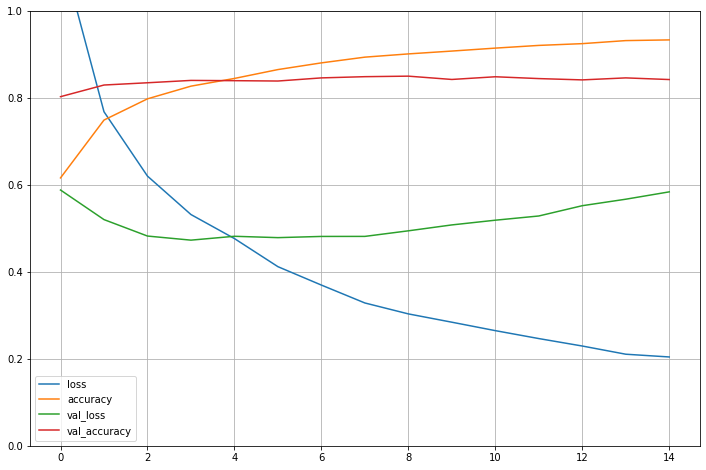

In [ ]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 41s 130ms/step - loss: 0.5578 - accuracy: 0.8446


[0.5577884316444397, 0.8446000218391418]

## Save the model

Save and upload your trained model to the **Seafile link** we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [ ]:
model.save('FDS22-M0-CIFAR10.h5') # change the file name according to your repository name

from google.colab import files
files.download('FDS22-M0-CIFAR10.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the model and evaluate it on the test data

In [ ]:
model = keras.models.load_model('FDS22-M0-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 42s 131ms/step - loss: 0.5578 - accuracy: 0.8446


[0.5577884316444397, 0.8446000218391418]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model and the difficulties you met.